# Predicting Units of Product Sold Daily

## Business Understanding

Understanding the demand of products is one of the most difficult problems for all businesses that produce physical goods. Even understanding the demand of a single product marketed to a single consumer base can be extremely challenging work. This challenge is compounded when dealing with the variety of products in the variety of markets that Wal-Mart is involved in. Developing a generalizable model that can be used to understand demand could give Wal-Mart a significant competitive edge over competition. An important factors that allowed Wal-Mart to keep its prices competitive and consolidate so many markets was its efficient supply chain. [Profitworks](https://profitworks.ca/small-business-sales-and-marketing-resources/blog/marketing-strategy/579-sam-walton-wal-mart-what-is-wal-mart-s-secret-to-success.html), a marketing agency, credits one of the largest reasons for Wal-Mart's national success as its extremely efficient supply chain. Being able to accurately forecast demand is imperative to efficiently running a supply chain whose supply can consistently meet demand without having an excessive amount of inventory. Keeping all products available and properly managing inventory can be difficult, and it becomes exponentially more difficult when storage bins are cluttered and/or full. Managing this balance, especially in stores with less space for inventory such as Wal-Mart Neighborhood Markets, can demand high levels of precision. 

## Data Understanding

The data used in this analysis can be found from the M5 Forecasting - Accuracy competition on Kaggle. It contains a 5 files: calendar.csv, sales_train_validation.csv, sample_submission.csv, sell_prices.csv, and sales_train_evaluation.csv. The calendar.csv file contains the date for every day, as well as the weekday, month, and Wal-Mart week. It also includes information of the days holiday status, and the days when snap is available. The sales_train_validation.csv contains information on the amount of units sold every day for 3019 different products across 10 different Wal-Mart stores in three different states. The sales_train_evaluation data contains the same information as the validation data, along with the correct values for the 28 day forecast. The sample_submission.csv contains an example csv for the format needed to submit the 28 day forecasts. The sell_prices.csv contains the prices at which the items were sold for every Wal-Mart week.

In [1]:
# imports for notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [2]:
# read in the dates and their recorded unique characteristics
dates = pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/calendar.csv', parse_dates=[0])

In [3]:
# take a look at the dates df
dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int64         
 2   weekday       1969 non-null   object        
 3   wday          1969 non-null   int64         
 4   month         1969 non-null   int64         
 5   year          1969 non-null   int64         
 6   d             1969 non-null   object        
 7   event_name_1  162 non-null    object        
 8   event_type_1  162 non-null    object        
 9   event_name_2  5 non-null      object        
 10  event_type_2  5 non-null      object        
 11  snap_CA       1969 non-null   int64         
 12  snap_TX       1969 non-null   int64         
 13  snap_WI       1969 non-null   int64         
dtypes: datetime64[ns](1), int64(7), object(6)
memory usage: 215.5+ KB


In [4]:
# most days have no event, replace NaN with "None"
dates.replace(np.NaN, 'None', inplace=True)

Some days have multiple events. One hot encoding will not be able to represent columns with multiple events, so the information will need to be in a format that the MultiLabelBinarizer can use. I'll make a new column that contains a list of all events on a given day. 

In [5]:
# remove spaces from all the events names
dates['event_name_1'] = dates['event_name_1'].str.replace(' ', '')
dates['event_name_2'] = dates['event_name_2'].str.replace(' ', '')

In [6]:
# create event column that contains a string of both events with a space between
dates['event'] = dates['event_name_1'] + ' ' + dates['event_name_2']

In [7]:
# split will turn the string into a list of both events
dates['event'] = dates['event'].str.split()

In [8]:
# removes the second element from the list when it is None
dates['event'] = dates['event'].apply(lambda x: [x[0]] if x[1] == 'None' else x)

In [9]:
# instantiat the MultiLabelBinarizer and fit it to the event column
mlb = MultiLabelBinarizer()
mlb.fit(dates['event'])
values = pd.DataFrame(mlb.transform(dates['event']), columns=mlb.classes_)

In [10]:
# adds the encoded columns to the dates dataframe
dates = pd.concat([dates, values], axis=1)

In [11]:
# drops the redundant event columns from dates
dates.drop(columns=['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'event'], inplace=True)

In [12]:
# instantiate the OneHotEncoder and fit it to weekday and month columns
ohe = OneHotEncoder(sparse=False)
ohe.fit(dates[['weekday', 'month']])
values = ohe.transform(dates[['weekday', 'month']])
values = pd.DataFrame(values, columns=ohe.get_feature_names())

In [13]:
# add the one hot encoded columns to the dates dataframe
dates = pd.concat([dates, values], axis=1)

In [14]:
# drop the unnecessary columns from the dates dataframe
dates.drop(columns=['wday', 'year', 'month', 'weekday'], inplace=True)

In [15]:
# read in the data for units sold
val = pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/sales_train_validation.csv')

In [16]:
# select data only from store CA_1
CA1 = val[val['store_id'] == 'CA_1']

In [18]:
# select only the data from department FOODS_1 in store CA_1 
CA1_F1 = val[(val['store_id'] == 'CA_1')&(val['dept_id'] == 'FOODS_1')]

In [19]:
# reducing the unnecessary columns to make the melt faster
CA1.drop(columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], inplace=True)

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [20]:
# make an iterable array of all the unique ids 
items = CA1['id'].unique()

In [21]:
# convert the dataframe into long format
CA1_ts = CA1.melt(id_vars=['id'], var_name='d', value_name='sales')

In [22]:
# read in the data on the prices for the products
prices = pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/sell_prices.csv')

In [23]:
# make a new id column that matches the format of the id column in CA1_ts
prices['id'] = prices['item_id'] + '_' + prices['store_id'] + '_validation'

In [24]:
# 30490 total items
len(val)

30490

In [25]:
# the sell prices are present for all 30490 items for the final week, matches length of val dataframe
(prices['wm_yr_wk'] == 11621).sum()

30490

In [26]:
# create a dataframe with the information from all dataframes
CA1_price = CA1_ts.merge(dates.drop(columns=['snap_TX', 'snap_WI']), on='d').merge(prices.drop(columns=['store_id', 'item_id']), on=['id', 'wm_yr_wk'], how='left')

## Exploratory Data Analysis

In [27]:
CA1_price.head()

,id,d,sales,date,wm_yr_wk,snap_CA,ChanukahEnd,Christmas,CincoDeMayo,ColumbusDay,...,x1_4,x1_5,x1_6,x1_7,x1_8,x1_9,x1_10,x1_11,x1_12,sell_price
0,HOBBIES_1_001_CA_1_validation,d_1,0,2011-01-29,11101,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,HOBBIES_1_002_CA_1_validation,d_1,0,2011-01-29,11101,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,HOBBIES_1_003_CA_1_validation,d_1,0,2011-01-29,11101,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,HOBBIES_1_004_CA_1_validation,d_1,0,2011-01-29,11101,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,HOBBIES_1_005_CA_1_validation,d_1,0,2011-01-29,11101,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [28]:
# summary statistics of the numerical variables
CA1_price.describe()

,sales,wm_yr_wk,snap_CA,ChanukahEnd,Christmas,CincoDeMayo,ColumbusDay,Easter,EidAlAdha,Eidal-Fitr,...,x1_4,x1_5,x1_6,x1_7,x1_8,x1_9,x1_10,x1_11,x1_12,sell_price
count,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,...,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,5.832737e+06,4.702895e+06
mean,1.319829e+00,1.133919e+04,3.293257e-01,2.613696e-03,2.613696e-03,2.613696e-03,2.613696e-03,3.136435e-03,2.613696e-03,2.613696e-03,...,9.095661e-02,8.102457e-02,7.841087e-02,8.102457e-02,8.102457e-02,7.841087e-02,8.102457e-02,7.841087e-02,8.102457e-02,4.411276e+00
std,4.058652e+00,1.503742e+02,4.699684e-01,5.105747e-02,5.105747e-02,5.105747e-02,5.105747e-02,5.591599e-02,5.105747e-02,5.105747e-02,...,2.875474e-01,2.728729e-01,2.688171e-01,2.728729e-01,2.728729e-01,2.688171e-01,2.728729e-01,2.688171e-01,2.728729e-01,3.395051e+00
min,0.000000e+00,1.110100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02
25%,0.000000e+00,1.121700e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.220000e+00
50%,0.000000e+00,1.133300e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.470000e+00
75%,1.000000e+00,1.144800e+04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.770000e+00
max,6.480000e+02,1.161300e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.098000e+01


In [29]:
# summary statistics for non numerical values
CA1_price.describe(include='object')

,id,d
count,5832737,5832737
unique,3049,1913
top,FOODS_3_378_CA_1_validation,d_498
freq,1913,3049


### Missing Prices

There are several missing prices in the dataframe, which could cause a big problem when modeling. However, upon further inspection, there were always zero sales of a product when it the products price was missing. This suggests that the price was not entered for these weeks because it was not on the shelves for those weeks. The weeks where the price is missing can easily be dropped when fitting the model as they will not be representative of the actual demand of the product. 

In [35]:
# there are several nulls after left joining with prices
CA1_price['sell_price'].isna().sum()

1129842

In [40]:
# there are never any sales of a product when its price is missing for the week
((CA1_price['sales'] == 0)&(CA1_price['sell_price'].isna())).sum()

1129842

In [31]:
CA1_price.groupby('date')['sales'].sum()

date
2011-01-29    4337
2011-01-30    4155
2011-01-31    2816
2011-02-01    3051
2011-02-02    2630
              ... 
2016-04-20    3722
2016-04-21    3709
2016-04-22    4387
2016-04-23    5577
2016-04-24    6113
Name: sales, Length: 1913, dtype: int64

### Data Challenges

One of the most challenging parts of finding a model that can accurately predict the number of units sold is the extremely noisy nature of the data. The total number of items sold every day varies hugely. The standard deviation of total items sold is 992 items per day, where the mean number of items sold is 4024 items per day. Looking at the Total Items Sold per Day graph below clearly illustrates this. This variation is after aggregating together all the items sold in the entire store. This high variance becomes an even greater issue when looking at the number of units sold for a singular item. For example, the item 43 from the Hobbies 1 department sells, on average, 3.29 units per day. However, the standard deviation is even larger than the mean number of units sold, at 5.13 units a day. Looking at the Total Units Sold per Day graph below illustrates this huge variance. It also depicts another issue with predicting units sold; a huge proportion of the items sell 0 units a majority of the days. In fact, 55% of the entries show zero units sold for the day. This high daily volatility can make it extremely challenging to give reasonable numbers at a daily frequency. It is very likely that large proportion of this noise is irreducible, so expectations for the model will need to take this into account. 

In [56]:
CA1_price.groupby('date')['sales'].sum().mean()

4024.1589127025613

In [55]:
CA1_price.groupby('date')['sales'].sum().std()

991.8472057455526

In [33]:
sns.set_context('poster')

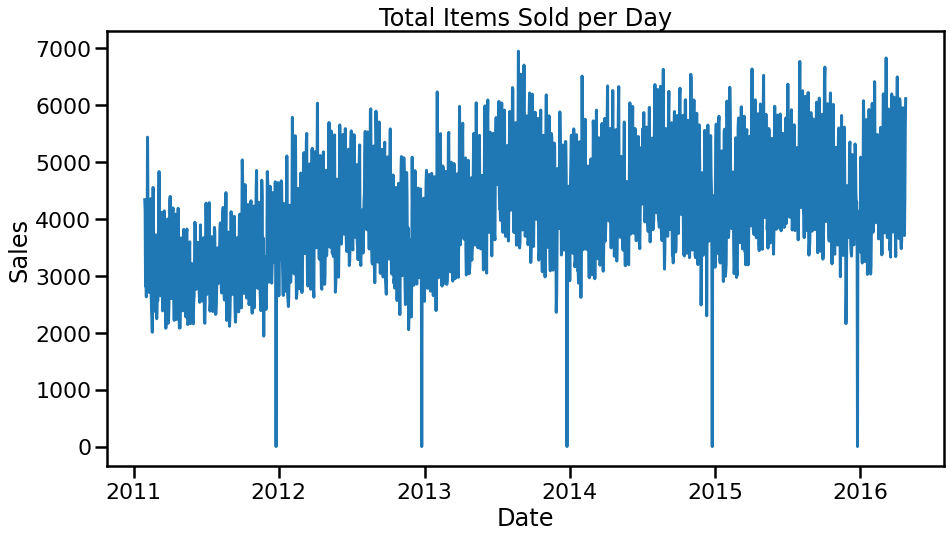

In [53]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=CA1_price.groupby('date')['sales'].sum(), ax=ax)
ax.set_title('Total Items Sold per Day')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.savefig('../images/total_items_sold.jpeg', facecolor='white');

In [58]:
CA1_price[CA1_price['id'] == items[42]]['sales'].std()

5.133077157392545

In [59]:
CA1_price[CA1_price['id'] == items[42]]['sales'].mean()

3.288029273392577

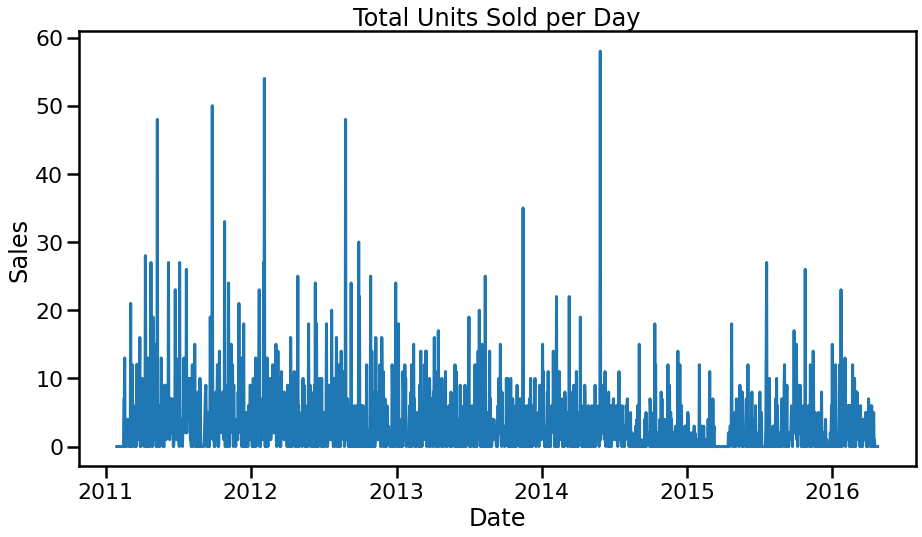

In [54]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=(CA1_price[CA1_price['id'] == items[42]].set_index('date')['sales']))
ax.set_title('Total Units Sold per Day')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.savefig('../images/total_units_sold', facecolor='white');

In [65]:
(CA1_price.dropna()['sales'] == 0).sum()

2600038

In [64]:
(CA1_price.dropna()['sales'] == 0).sum() / len(CA1_price.dropna())

0.552859036827316

### Sales by Department

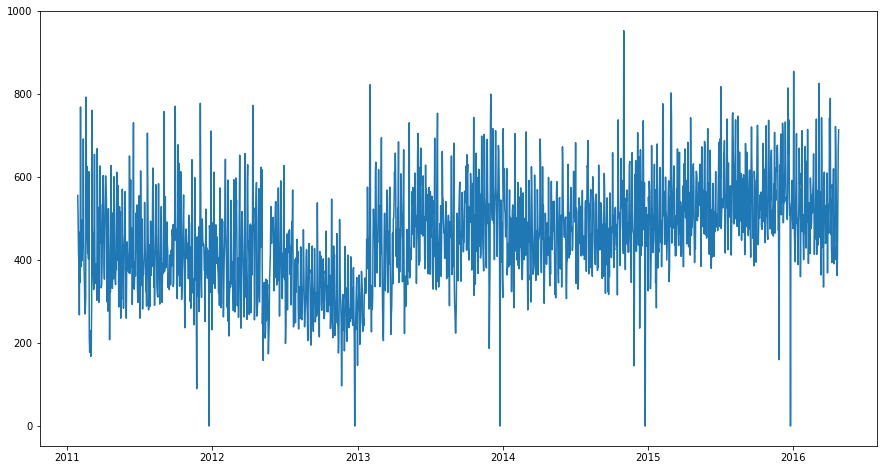

In [55]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(CA1_price[CA1_price['id'].str.contains('HOB')].groupby('date')['sales'].sum())

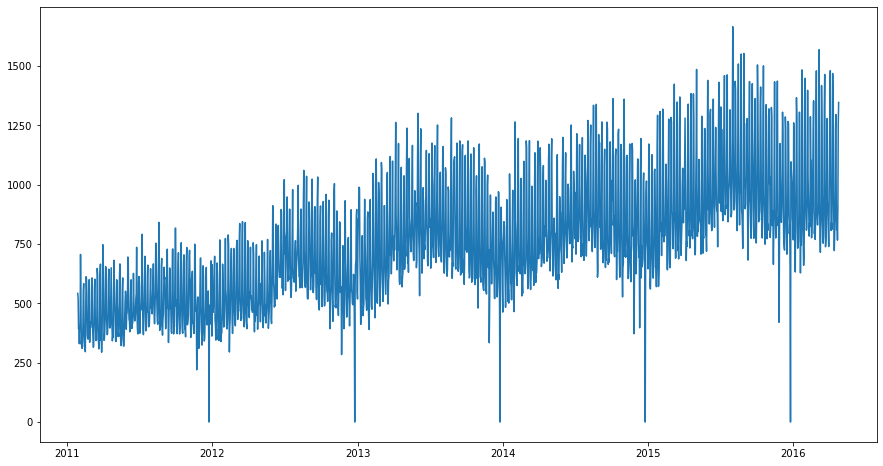

In [57]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(CA1_price[CA1_price['id'].str.contains('HOU')].groupby('date')['sales'].sum())

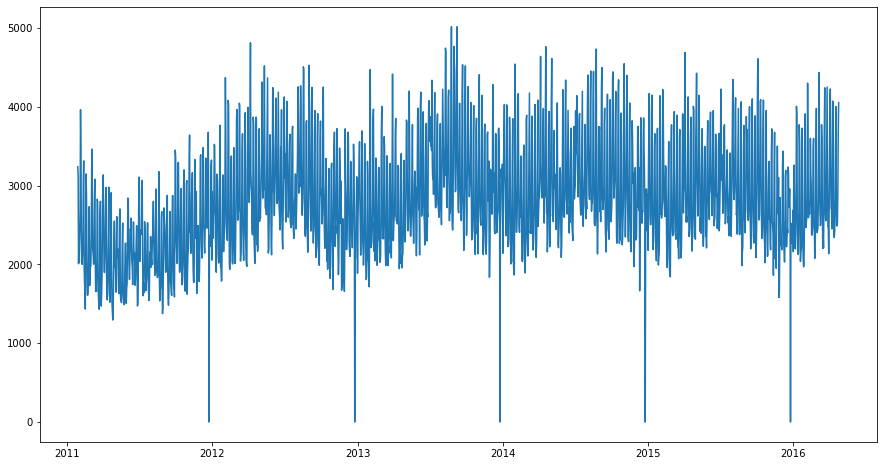

In [59]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(CA1_price[CA1_price['id'].str.contains('FOO')].groupby('date')['sales'].sum())

In [37]:
CA1_price

,id,d,sales,date,wm_yr_wk,snap_CA,ChanukahEnd,Christmas,CincoDeMayo,ColumbusDay,...,x1_4,x1_5,x1_6,x1_7,x1_8,x1_9,x1_10,x1_11,x1_12,sell_price
0,HOBBIES_1_001_CA_1_validation,d_1,0,2011-01-29,11101,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,HOBBIES_1_002_CA_1_validation,d_1,0,2011-01-29,11101,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,HOBBIES_1_003_CA_1_validation,d_1,0,2011-01-29,11101,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,HOBBIES_1_004_CA_1_validation,d_1,0,2011-01-29,11101,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,HOBBIES_1_005_CA_1_validation,d_1,0,2011-01-29,11101,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5832732,FOODS_3_823_CA_1_validation,d_1913,1,2016-04-24,11613,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.98
5832733,FOODS_3_824_CA_1_validation,d_1913,0,2016-04-24,11613,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.48
5832734,FOODS_3_825_CA_1_validation,d_1913,2,2016-04-24,11613,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.98
5832735,FOODS_3_826_CA_1_validation,d_1913,0,2016-04-24,11613,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.28


In [156]:
(CA1_F1_price['date'] == '2011-01-29').sum()

216

In [158]:
CA1_F1_price['lag_28'] = CA1_F1_price['sales'].shift(periods=216*28)

In [219]:
preds = []
trues = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item]
    test = ts['2016-03-28':]
    trues.append(test['sales'])
    preds.append(test['lag_28'])

In [220]:
RMSEs = []
for i in range(216):
    RMSEs.append(mean_squared_error(trues[i], preds[i], squared=False))

In [221]:
np.mean(RMSEs)

1.8183114470006307

In [312]:
CA1_F1_price['lag_28'].rolling(8).mean()

date
2011-01-30      NaN
2011-01-30      NaN
2011-01-30      NaN
2011-01-30      NaN
2011-01-30      NaN
              ...  
2016-04-24    0.000
2016-04-24    0.375
2016-04-24    0.875
2016-04-24    1.875
2016-04-24    2.125
Name: lag_28, Length: 351815, dtype: float64

In [319]:
CA1_F1_price['lag_28'].tail(28)

date
2016-04-24    0.0
2016-04-24    0.0
2016-04-24    3.0
2016-04-24    1.0
2016-04-24    0.0
2016-04-24    0.0
2016-04-24    2.0
2016-04-24    0.0
2016-04-24    6.0
2016-04-24    6.0
2016-04-24    0.0
2016-04-24    4.0
2016-04-24    3.0
2016-04-24    2.0
2016-04-24    8.0
2016-04-24    3.0
2016-04-24    0.0
2016-04-24    0.0
2016-04-24    0.0
2016-04-24    0.0
2016-04-24    0.0
2016-04-24    0.0
2016-04-24    0.0
2016-04-24    0.0
2016-04-24    3.0
2016-04-24    4.0
2016-04-24    8.0
2016-04-24    2.0
Name: lag_28, dtype: float64

In [318]:
CA1_F1_price[CA1_F1_price['id'] == 'FOODS_1_219_CA_1_validation']['lag_28'].tail(28)

date
2016-03-28    3.0
2016-03-29    6.0
2016-03-30    5.0
2016-03-31    3.0
2016-04-01    0.0
2016-04-02    3.0
2016-04-03    8.0
2016-04-04    5.0
2016-04-05    2.0
2016-04-06    4.0
2016-04-07    1.0
2016-04-08    3.0
2016-04-09    1.0
2016-04-10    4.0
2016-04-11    6.0
2016-04-12    4.0
2016-04-13    2.0
2016-04-14    1.0
2016-04-15    4.0
2016-04-16    4.0
2016-04-17    3.0
2016-04-18    6.0
2016-04-19    6.0
2016-04-20    1.0
2016-04-21    0.0
2016-04-22    1.0
2016-04-23    4.0
2016-04-24    2.0
Name: lag_28, dtype: float64

In [28]:
# 61292 missing price values
CA1_F1_price['sell_price'].isna().sum()

61292

In [29]:
# Every single time the price is missing, there are no sales
((CA1_F1_price['sell_price'].isna())&(CA1_F1_price['sales'] == 0)).sum()

61292

In [163]:
CA1_F1_price.dropna(inplace=True)

In [164]:
CA1_F1_price['d'] = CA1_F1_price['d'].str.replace('d_', '').astype(int)

In [171]:
CA1_F1_price.drop(columns=['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'event'], inplace=True)

In [176]:
CA1_F1_price.set_index('date', inplace=True)

In [209]:
preds = []
trues = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    rf = RandomForestRegressor().fit(X_train, y_train)
    preds.append(rf.predict(X_test))
    trues.append(y_test)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    importances.append(rf.feature_importances_)

In [215]:
np.mean(train_scores)

0.5524568116848505

In [216]:
np.mean(test_scores)

-0.22585515756620791

In [217]:
RMSEs = []
for i in range(216):
    RMSEs.append(mean_squared_error(trues[i], preds[i], squared=False))

In [218]:
np.mean(RMSEs)

1.4917644039246414

In [227]:
preds = []
trues = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    xgb = XGBRegressor().fit(X_train, y_train)
    preds.append(xgb.predict(X_test))
    trues.append(y_test)
    train_scores.append(xgb.score(X_train, y_train))
    test_scores.append(xgb.score(X_test, y_test))
    importances.append(xgb.feature_importances_)

In [228]:
np.mean(train_scores)

0.8949888703594413

In [229]:
np.mean(test_scores)

-1.26556087486873

In [230]:
RMSEs = []
for i in range(216):
    RMSEs.append(mean_squared_error(trues[i], preds[i], squared=False))

In [231]:
np.mean(RMSEs)

1.9247628696121823

In [214]:
preds = []
trues = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    lgbm = LGBMRegressor().fit(X_train, y_train)
    preds.append(lgbm.predict(X_test))
    trues.append(y_test)
    train_scores.append(lgbm.score(X_train, y_train))
    test_scores.append(lgbm.score(X_test, y_test))
    importances.append(lgbm.feature_importances_)

In [193]:
for pred in preds:
    pred[pred < 0] = 0

In [189]:
preds

[array([0.43800372, 0.56157198, 0.84040732, 0.64755176, 0.62397097,
        0.96548823, 0.32786325, 1.16319308, 0.47925759, 1.35713543,
        0.43927371, 0.84690325, 1.03046754, 0.98449991, 0.76559798,
        0.76465471, 0.77963582, 0.35304895, 0.72303992, 1.0299443 ,
        0.82713113, 0.47765905, 0.65423307, 1.15164699, 0.33448149,
        0.45613931, 0.83469697, 0.74291507]),
 array([ 0.20622213,  0.3360104 ,  0.53901561,  0.2896914 ,  0.47699873,
         0.00872392,  0.46698587,  0.36267727,  0.12215601,  0.09284693,
         0.19834826,  0.21799892,  0.29491186,  0.26114442,  0.22544538,
        -0.07998771,  0.50354172,  0.57701413,  0.34521969,  0.44153373,
         0.05676968,  0.09683433,  0.43524591,  0.50660791,  0.30980568,
         0.31155182,  0.46280622,  0.41406952]),
 array([1.44042803, 0.34040306, 0.90979297, 0.39985395, 0.33229313,
        0.46246364, 1.12813185, 1.40480432, 0.09306718, 0.68117959,
        0.28083839, 0.69567872, 1.08456977, 0.74986547, 0.902208

In [190]:
trues

[date
 2016-03-28    2
 2016-03-29    1
 2016-03-30    1
 2016-03-31    0
 2016-04-01    4
 2016-04-02    0
 2016-04-03    0
 2016-04-04    4
 2016-04-05    1
 2016-04-06    3
 2016-04-07    0
 2016-04-08    1
 2016-04-09    0
 2016-04-10    2
 2016-04-11    2
 2016-04-12    0
 2016-04-13    1
 2016-04-14    1
 2016-04-15    0
 2016-04-16    2
 2016-04-17    0
 2016-04-18    4
 2016-04-19    1
 2016-04-20    1
 2016-04-21    0
 2016-04-22    1
 2016-04-23    1
 2016-04-24    0
 Name: sales, dtype: int64,
 date
 2016-03-28    0
 2016-03-29    1
 2016-03-30    0
 2016-03-31    0
 2016-04-01    0
 2016-04-02    0
 2016-04-03    0
 2016-04-04    0
 2016-04-05    0
 2016-04-06    1
 2016-04-07    0
 2016-04-08    0
 2016-04-09    0
 2016-04-10    0
 2016-04-11    1
 2016-04-12    0
 2016-04-13    0
 2016-04-14    1
 2016-04-15    1
 2016-04-16    3
 2016-04-17    1
 2016-04-18    0
 2016-04-19    0
 2016-04-20    1
 2016-04-21    2
 2016-04-22    0
 2016-04-23    0
 2016-04-24    0
 Name: s

In [194]:
RMSEs = []
for i in range(216):
    RMSEs.append(mean_squared_error(trues[i], preds[i], squared=False))

In [195]:
np.mean(RMSEs)

1.635301116269365

In [196]:
importances

[array([280, 230, 220,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,  58,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0, 109, 105,  93, 103,  60,
         72, 103,  36,  53,  73,  46,  67,  81,  54, 103,  40,  45,  64,
         73, 218, 614]),
 array([292, 221, 244,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,  68,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  86, 101,  89, 117, 117,
         73,  64,  49,  85,  63,  61,  80,  90,  70,  72,  57,  49,  66,
         46, 360, 380]),
 array([267, 249, 229,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,  87,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  63, 105,  88,  77,  81,
         62,  60,  59,  68,  55,  41, 101,  54,  46,  67,  58,  71,  30,
         63, 230, 689]),
 array([ 163,  118,  123,    0,    0,    0,    0,

In [222]:
preds = []
trues = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    lgbm2 = LGBMRegressor(objective='tweedie').fit(X_train, y_train)
    preds.append(lgbm2.predict(X_test))
    trues.append(y_test)
    train_scores.append(lgbm2.score(X_train, y_train))
    test_scores.append(lgbm2.score(X_test, y_test))
    importances.append(lgbm2.feature_importances_)

In [223]:
np.mean(train_scores)

0.6183382619086748

In [224]:
np.mean(test_scores)

-0.23935959329311823

In [225]:
RMSEs = []
for i in range(216):
    RMSEs.append(mean_squared_error(trues[i], preds[i], squared=False))

In [226]:
np.mean(RMSEs)

1.481867889453839

In [240]:
preds = []
trues = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    lgbm3 = LGBMRegressor(objective='tweedie', max_depth=5).fit(X_train, y_train)
    preds.append(lgbm3.predict(X_test))
    trues.append(y_test)
    train_scores.append(lgbm3.score(X_train, y_train))
    test_scores.append(lgbm3.score(X_test, y_test))
    importances.append(lgbm3.feature_importances_)

In [241]:
np.mean(train_scores)

0.4231629876044877

In [242]:
np.mean(test_scores)

-0.2049734069759267

In [243]:
RMSEs = []
for i in range(216):
    RMSEs.append(mean_squared_error(trues[i], preds[i], squared=False))

In [244]:
np.mean(RMSEs)

1.4627363396686461

In [268]:
preds = []
trues = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    lgbm4 = LGBMRegressor(objective='tweedie', max_depth=5, reg_alpha=5, reg_lambda=5).fit(X_train, y_train)
    preds.append(lgbm4.predict(X_test))
    trues.append(y_test)
    train_scores.append(lgbm4.score(X_train, y_train))
    test_scores.append(lgbm4.score(X_test, y_test))
    importances.append(lgbm4.feature_importances_)

In [269]:
np.mean(train_scores)

0.3374336477148698

In [270]:
np.mean(test_scores)

-0.12552314049765806

In [272]:
RMSEs = []
for i in range(216):
    RMSEs.append(mean_squared_error(trues[i], preds[i], squared=False))

In [273]:
np.mean(RMSEs)

1.4216511358671393

In [302]:
preds = []
trues = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    lgbm5 = LGBMRegressor(objective='tweedie', max_depth=8, reg_alpha=5, reg_lambda=5).fit(X_train, y_train)
    preds.append(lgbm5.predict(X_test))
    trues.append(y_test)
    train_scores.append(lgbm5.score(X_train, y_train))
    test_scores.append(lgbm5.score(X_test, y_test))
    importances.append(lgbm5.feature_importances_)

In [303]:
np.mean(train_scores)

0.3878222547786668

In [304]:
np.mean(test_scores)

-0.1262605434239212

In [305]:
RMSEs = []
for i in range(216):
    RMSEs.append(mean_squared_error(trues[i], preds[i], squared=False))

In [306]:
np.mean(RMSEs)

1.4234435435576729

In [307]:
preds = []
trues = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    lgbm6 = LGBMRegressor(objective='tweedie', max_depth=8, num_leaves=63, reg_alpha=10, reg_lambda=10).fit(X_train, y_train)
    preds.append(lgbm6.predict(X_test))
    trues.append(y_test)
    train_scores.append(lgbm6.score(X_train, y_train))
    test_scores.append(lgbm6.score(X_test, y_test))
    importances.append(lgbm6.feature_importances_)

In [308]:
np.mean(train_scores)

0.30332831727692455

In [309]:
np.mean(test_scores)

-0.11649224969706638

In [310]:
RMSEs = []
for i in range(216):
    RMSEs.append(mean_squared_error(trues[i], preds[i], squared=False))

In [311]:
np.mean(RMSEs)

1.409228119188317

In [320]:
preds = []
trues = []
train_scores = []
test_scores = []
importances = []
for item in items:
    ts = CA1_F1_price[CA1_F1_price['id'] == item].drop(columns=['id'])
    train = ts[:'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    lgbm6 = LGBMRegressor(objective='tweedie', n_estimators=500, max_depth=8, num_leaves=63, reg_alpha=10, reg_lambda=10).fit(X_train, y_train)
    preds.append(lgbm6.predict(X_test))
    trues.append(y_test)
    train_scores.append(lgbm6.score(X_train, y_train))
    test_scores.append(lgbm6.score(X_test, y_test))
    importances.append(lgbm6.feature_importances_)

In [321]:
np.mean(train_scores)

0.3073240245852358

In [322]:
np.mean(test_scores)

-0.11645447882040985

In [323]:
RMSEs = []
for i in range(216):
    RMSEs.append(mean_squared_error(trues[i], preds[i], squared=False))

In [324]:
np.mean(RMSEs)

1.4104239391420565

## Thoughts

- need to take into account different types of items, if you're selling Christmas items after Christmas for a reduced price, does it actually reflect the demand of the product
- need to take into account marketing, end-caps, and how close to eye-level the products, how do these effect demand
- need to take into account inventory, sometimes something has high demand but lack of inventory fails to reflect the full demand, like Oatly milk.
- need to talk about the skepticism of just in time manufacturing and how this could change this. 
- need to talk about the variety of products provided at markets and how this can lead to more confusing numbers.